In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src/'))

### Loading model and computing embeddings

In [2]:
import cicids2017
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.manifold import TSNE
from umap import UMAP


# MODELPATH = Path(f"../res/Seq2Seq.torch")
MODELPATH = Path(f"../res/GruLinearTL.torch")
DATASETPATH_CACHE = Path(f"../dataset/cache")
TARGET_DSET = "DT"


# net = cicids2017.configureSeq2Seq(None, checkpoint=MODELPATH)
net = cicids2017.configureAnchor(None, checkpoint=MODELPATH)

netdata = cicids2017.load_dataset(DATASETPATH_CACHE)[TARGET_DSET]    
netdata = net.pointwise_embedding(netdata)
netdata = pd.concat(netdata)


# Remove truncated embeddings
netdata = netdata.loc[netdata["_embedding"].dropna().index]
tsne_input = np.stack(netdata["_embedding"].values)
netdata["_ebs2D"] = list(TSNE(n_components=2).fit_transform(tsne_input))

/Users/swedishhdcamera/Desktop/Projects/tesi_sabella/venv/lib/python3.8/site-packages/skorch/dataset.py:267: FutureWarning: Setting a random_state has no effect since cv is not a float. This will raise an error in a future. You should leave random_state to its default (None), or set cv to a float value.
  warnings.warn(


In [3]:
# channels = [ c for c in netdata.columns if c[0]!="_" ]
# netdata["_ebs2D"] = list(TSNE(n_components=2).fit_transform(netdata[channels].values))

# Minor changes to dataset

In [10]:
netdata["_group_anomaly"] = netdata["_isanomaly"]

def rename_anomaly(pattern, newname):
    netdata.loc[netdata["_group_anomaly"].str.contains(pattern), "_group_anomaly"] = newname
    
rename_anomaly("Web Attack", "Web Attack")
rename_anomaly("Brute Force", "Brute Force")
rename_anomaly("DoS", "DoS")
rename_anomaly("DDoS", "DDoS")
rename_anomaly("NMap", "NMap")
rename_anomaly("Port Scan", "NMap")

netdata = netdata.reset_index()

### Computing clustering

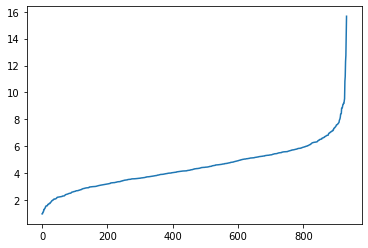

In [11]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

X = np.stack(netdata["_ebs2D"].sample(frac=.1))
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
third_nn = distances[:, 4]

plt.plot(np.sort(third_nn))

In [16]:
from sklearn.cluster import DBSCAN

cluster_algorithm = DBSCAN(eps=4, min_samples=5) # TL
# cluster_algorithm = DBSCAN(eps=6, min_samples=5) # AE

cluster_str = str(cluster_algorithm).split('(')[0]
clustering_input = np.stack(netdata["_ebs2D"].values)
clustering = cluster_algorithm.fit(clustering_input)
netdata["_clustering"] = clustering.labels_.astype(str)

### Display

In [13]:
netdata.loc[netdata["_host"] == "192.168.10.255", "_device_category"] = "broadcast"

In [14]:
import warnings
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import Button, Layout
from datetime import datetime
# warnings.filterwarnings("ignore")
from umap import UMAP
import pandas as pd
import matplotlib.patches as mpatches
from pprint import pprint
import numpy as np
from ipywidgets import HBox, VBox, interactive
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from IPython.display import display, Markdown
import ipywidgets as widgets
import math
from sklearn.manifold import TSNE
import torch
from ipywidgets import interact, interact_manual
from IPython.display import set_matplotlib_formats
from importlib import reload
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN

In [17]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox, interactive



DAY2INT = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4}
INT2DAY = {v: k for k, v in DAY2INT.items()}


# ----- ----- COLORMAPS ----- ----- #
# ----- ----- --------- ----- ----- #
def ncolors(n, seed=421):
    seed = np.random.randint(10000)
    print(seed)
    np.random.seed(seed)
    hexl = list('0123456789ABCDEF')
    hexc = np.random.choice(hexl, size=(n, 6))
    return ['#' + ''.join(x) for x in hexc]

devices = set([(c, h) for (c, h) in zip(netdata["_device_category"], netdata["_host"])])
colorsmap = np.concatenate([ np.unique(netdata["_group_anomaly"]),
                             np.unique(netdata["_isanomaly"]),
                             np.unique(netdata["_clustering"]),
                             [ dev[0] for dev in devices],
                             [ dev[1] for dev in devices]])  
colorsmap = dict(zip(colorsmap, ncolors(len(colorsmap))))
# colorsmap["192.168.10.50"] = colorsmap["1"]
colorsmap["server"] = "#2d53ac"
colorsmap["broadcast"] = "#b4a9b0"
colorsmap["unknown device class"] = "#7e7629"
colorsmap["pc"] = "#e2c484"

colorsmap["192.168.10.50"] = "#2d53ac"
colorsmap["Brute Force"] = "#b4a9b0"
colorsmap["DoS"] = "#7e7629"
colorsmap["NMap"] = "#e2c484"
colorsmap["Web Attack"] = "#c499cb"
colorsmap["Infiltration__Nmap - Portscan"] = "#00ca40"


# ----- ----- WIDGETS ----- ----- #
# ----- ----- ------- ----- ----- #
devices_str = [f"{h} ({c})" for c, h in devices]
devices_str.sort()                               
device_w_list = widgets.Dropdown(options=["ALL"] + devices_str)

weekdays = np.unique(netdata["_time"].dt.dayofweek)
available_days = list(map(lambda x: INT2DAY[x], weekdays))
days_w_list = widgets.Dropdown(options=["ALL"]+available_days)

available_attacks = list(np.unique(netdata["_isanomaly"]))
show_attacks_dropdown = widgets.Dropdown(options=["ALL"]+available_attacks)

clusters = list(np.unique(netdata["_clustering"]))
show_cluster_dropdown = widgets.Dropdown(options=["NONE"]+clusters)
                               
hide_attacks_checkbox = widgets.Checkbox(value=False, description="Hide all attacks")
show_category_checkbox = widgets.Checkbox(value=False, description="Show category")
group_anomaly_checkbox = widgets.Checkbox(value=False, description="Group anomalies")
clustering_descr = f"Show clustering ({cluster_str})"
show_clustering_checkbox = widgets.Checkbox(value=False, description=clustering_descr)

ts0_selector = HBox([days_w_list, group_anomaly_checkbox])
ts1_selector = HBox([device_w_list, show_category_checkbox])
ts2_selector = HBox([show_attacks_dropdown, hide_attacks_checkbox])
ts3_selector = HBox([show_cluster_dropdown, show_clustering_checkbox])
wlist = VBox([ts0_selector, ts1_selector, ts2_selector, ts3_selector])


# ----- ----- INTERACTOR ----- ----- #
# ----- ----- ---------- ----- ----- #
def labeled_scatter(mask, labelname):
    data = netdata[mask]
    if len(data) == 0:
        return
    ebs2D = np.stack(data["_ebs2D"])
    x1 = ebs2D[:, 0]
    x2 = ebs2D[:, 1]
    
    labels = data[labelname]
    colors = map(lambda x: colorsmap[x], labels)
    colors = np.array(list(colors))
    #print(np.unique(labels))
    ax = plt.gca()
    for l in np.unique(labels):
        l_idxs = np.where(labels==l)[0]
        ax.scatter(x1[l_idxs], x2[l_idxs], color=colors[l_idxs], label=l)


def split_device_str(s):
    split = s.split(" ")
    host = split[0].strip()
    category = " ".join(split[1:]).replace("(", "").replace(")", "").strip()
    return host, category


def whandler(day, device, show_category, attack, hide_attacks, cluster_focus, show_clusters, attack_label):
    if show_category:
        show_label = "_device_category"
    elif show_clusters:
        show_label = "_clustering"
    else:
        show_label = "_host"
    
    data_len = len(netdata)
    mask = np.full(data_len, True)
    
    if day != "ALL":
        weekday = netdata["_time"].dt.dayofweek
        mask &= (weekday == DAY2INT[day])
    
    if device != "ALL":
        host, _ = split_device_str(device)
        mask &= (netdata["_host"] == host)
    
    if cluster_focus != "NONE":
        mask &= (netdata["_clustering"] == cluster_focus)
    
    # Plotting all but attacks traffic
    clean_mask = mask & (netdata["_isanomaly"] == "none")
    labeled_scatter(clean_mask, show_label)
    
    # Plottin attacks
    if not hide_attacks:
        if attack == "ALL":
            attack_mask = mask & (netdata["_isanomaly"] != "none")
        else:
            attack_mask = mask & (netdata["_isanomaly"] == attack)
        
        if show_clusters:
            show_label = "_clustering"
        elif attack_label:
            show_label = "_group_anomaly"
        else:
            show_label = "_isanomaly"
        
        attack_mask = attack_mask#& (netdata["_clustering"] != "-1")
        
        labeled_scatter(attack_mask, show_label)

    # Fixing repeating labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys()) #, bbox_to_anchor=(1, 0.5))
    plt.gcf().set_size_inches(10, 10)
    plt.savefig("RenameMe.png")
    plt.show()
    
%matplotlib inline
output = widgets.interactive(whandler,
                             day=days_w_list,
                             device=device_w_list, 
                             show_category=show_category_checkbox, 
                             attack=show_attacks_dropdown, 
                             hide_attacks=hide_attacks_checkbox,
                             cluster_focus=show_cluster_dropdown, 
                             show_clusters=show_clustering_checkbox,
                             attack_label=group_anomaly_checkbox).children[-1]
display(wlist)
display(output)

7874


Output()